In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

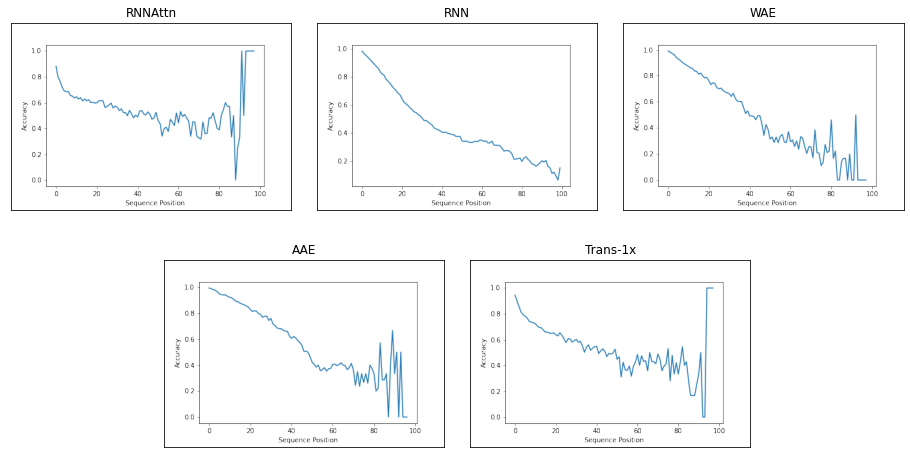

In [2]:
fig = plt.figure(figsize=(16,8))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
img = plt.imread("model_analyses//rnnattn-128_peptide_latent_64//token_position_accuracy.png")
ax1.set_title('RNNAttn')
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.imshow(img)

ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
img = plt.imread("model_analyses//rnn-128_peptide_latent_64//token_position_accuracy.png")
ax2.set_title('RNN')
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
plt.imshow(img)

ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
img = plt.imread("model_analyses//wae-128_peptide_latent_64//token_position_accuracy.png")
ax3.set_title('WAE')
ax3.xaxis.set_ticks([])
ax3.yaxis.set_ticks([])
plt.imshow(img)

ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
img = plt.imread("model_analyses//aae-128_peptide_latent_64//token_position_accuracy.png")
ax4.set_title('AAE')
ax4.xaxis.set_ticks([])
ax4.yaxis.set_ticks([])
plt.imshow(img)

ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
img = plt.imread("model_analyses//trans1x-128_peptide_latent_64//token_position_accuracy.png")
ax5.set_title('Trans-1x')
ax5.xaxis.set_ticks([])
ax5.yaxis.set_ticks([])
plt.imshow(img)

plt.savefig('token_acc.png', transparent=None)

In [3]:
import re
#From: https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [4]:
import re
df_list = []
glob_list = glob.glob("model_analyses"+"//**//*.csv", recursive = True) #searcg all the analyses to find the CSV's

ordered_glob_list = sorted_alphanumeric(glob_list) #problems with default ordering

for csv in ordered_glob_list:
    df_list.append([pd.read_csv(csv),csv]) #create and store a tuple which contains the dataframe and the directory
    print(csv)

model_analyses\aae-128_peptide_latent_32\saved_info.csv
model_analyses\aae-128_peptide_latent_64\saved_info.csv
model_analyses\rnn-128_peptide_latent_32\saved_info.csv
model_analyses\rnn-128_peptide_latent_64\saved_info.csv
model_analyses\rnn-128_peptide_latent_128\saved_info.csv
model_analyses\rnnattn-128_peptide_latent_32\saved_info.csv
model_analyses\rnnattn-128_peptide_latent_64\saved_info.csv
model_analyses\rnnattn-128_peptide_latent_128\saved_info.csv
model_analyses\trans1x-128_peptide_latent_32\saved_info.csv
model_analyses\trans1x-128_peptide_latent_64\saved_info.csv
model_analyses\trans1x-128_peptide_latent_128\saved_info.csv
model_analyses\wae-128_peptide_latent_32\saved_info.csv
model_analyses\wae-128_peptide_latent_64\saved_info.csv
model_analyses\wae-128_peptide_latent_128\saved_info.csv


In [5]:
metric_list = pd.DataFrame()
for df_tuple in df_list:
    df_tuple[0]['model'] = df_tuple[1] #add a column with the model name
    #grab 1st element of cols: 2->last
    metric_list = metric_list.append(df_tuple[0].loc[0,df_tuple[0].columns[2]:df_tuple[0].columns[-1]]) 

In [6]:
#shortens the names to fit well in the plots
model_names = [temp_list[:].split('\\')[1] for temp_list in metric_list['model'].tolist()]
model_names = [names.split('_')[0][:-4]+'-'+names.split('_')[3] for names in model_names] 

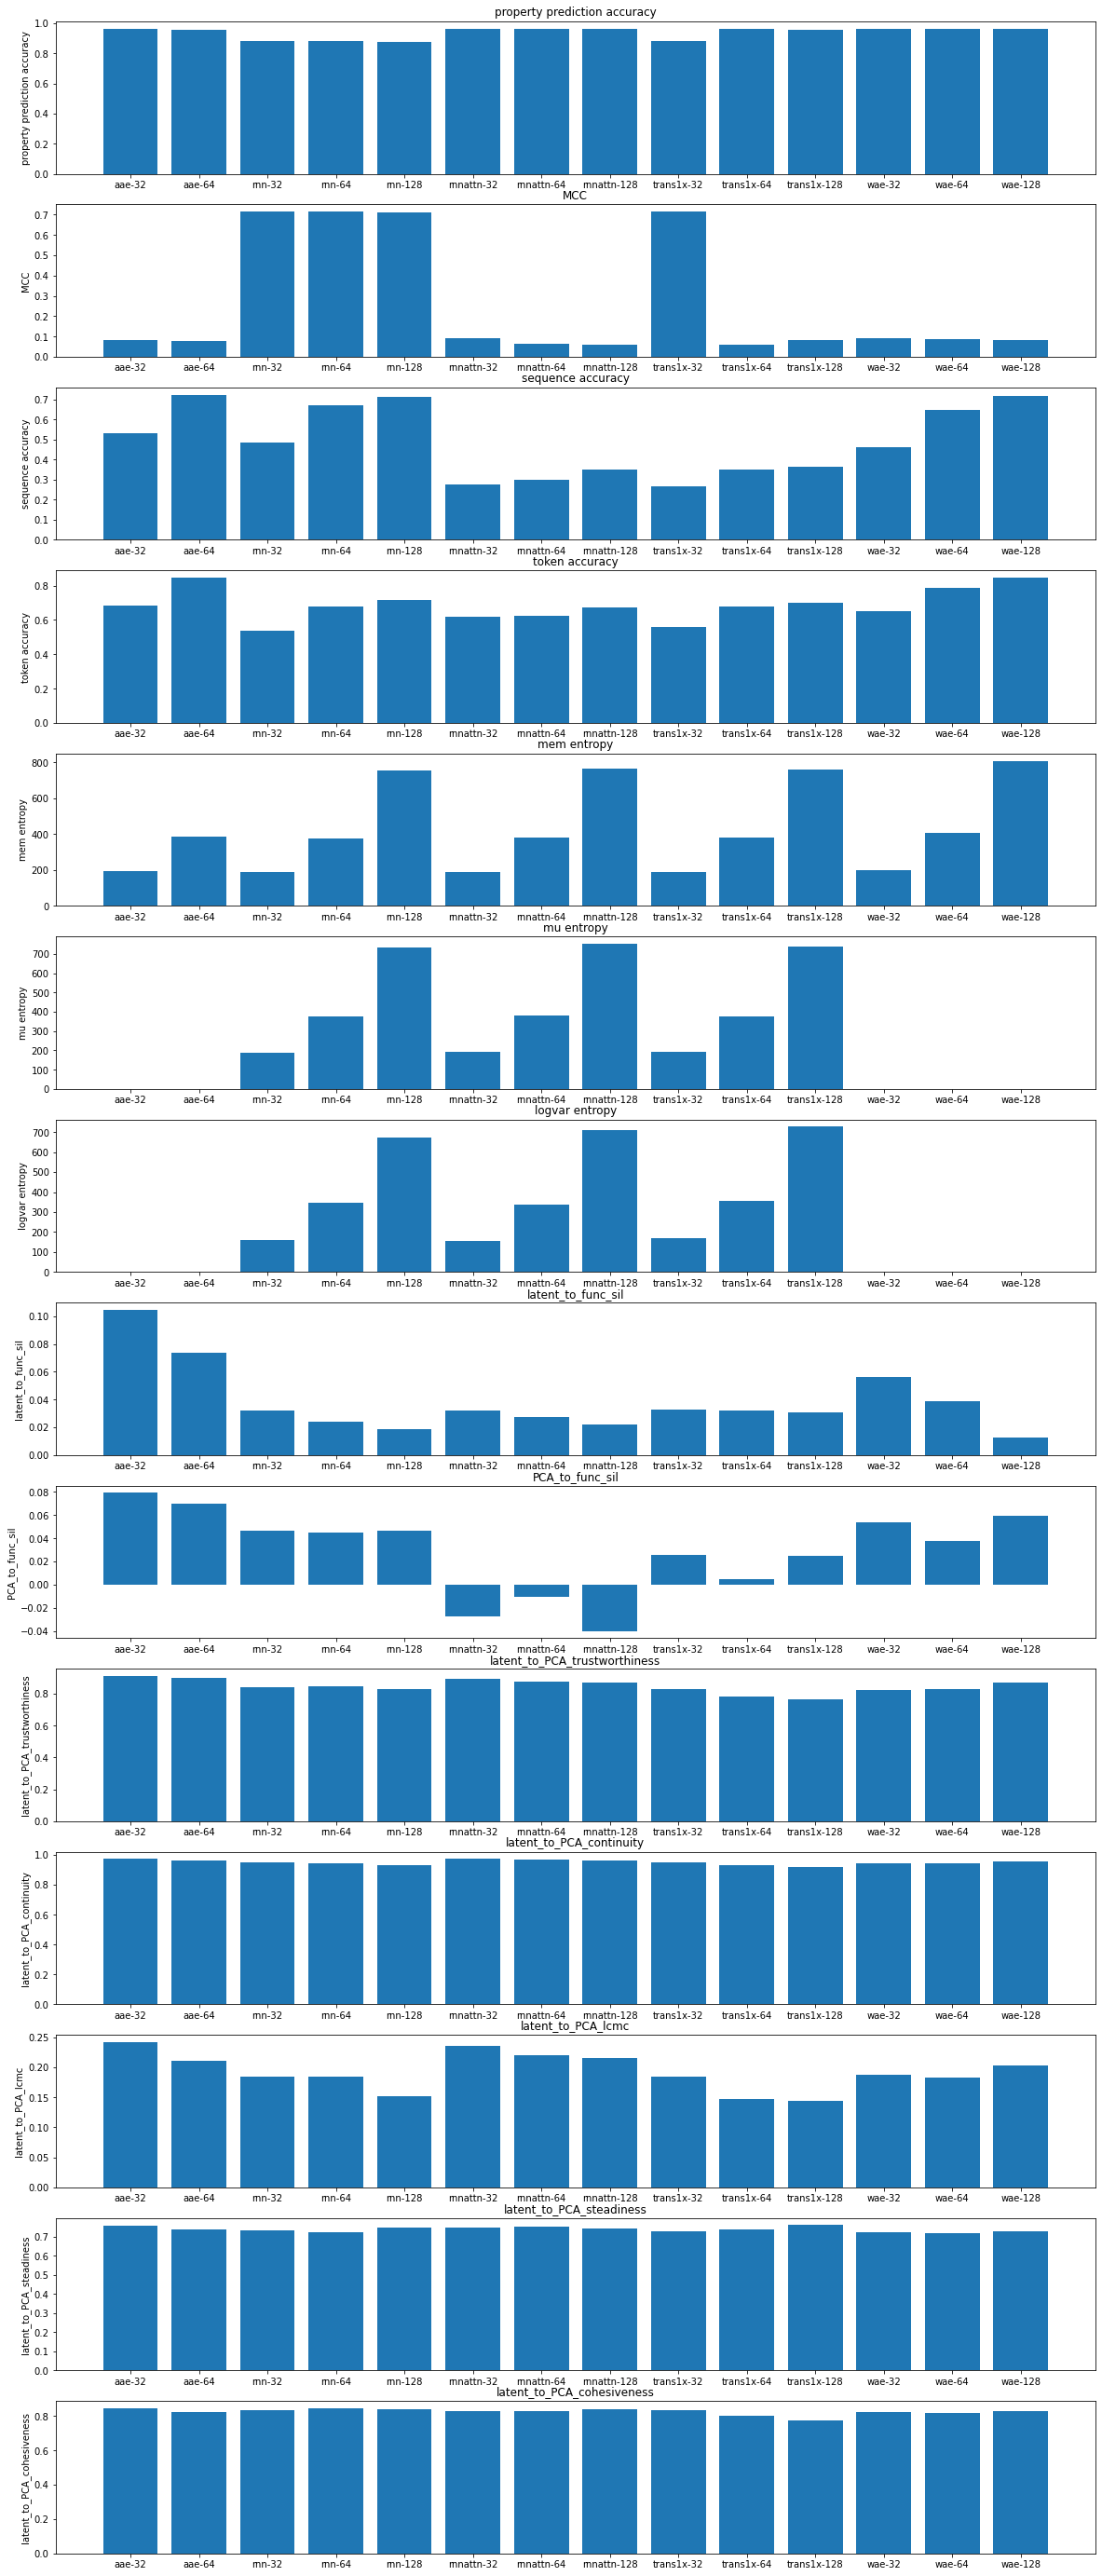

In [7]:
fig, ax = plt.subplots(len(metric_list.columns)-1,1, figsize=(20,50))

for col in range(len(metric_list.columns)-1):
    ax[col].bar(x=model_names,height=metric_list.iloc[:,col] ) 
    ax[col].set_title(metric_list.columns[col])
    ax[col].set_ylabel('{}'.format(metric_list.columns[col]))
plt.savefig('bar_metrics.jpg', transparent=None)
plt.show()


# for row in range(len(metric_list)):
#     rect_list.append(ax.bar(x=metric_list['model'],height=metric_list.iat[row,3], label=metric_list.columns[3]))
# ax.legend()
